In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import json
import gzip
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import time
import re
import scipy.sparse as sp
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

TRAINING_CONFIG = {
    'SAMPLE_SIZE': 30000,
    'BATCH_SIZE': 48,
    'EPOCHS': 10,
    'LEARNING_RATE': 2e-5,
    'DROPOUT': 0.4,
    'PATIENCE': 7,
    'MAX_LENGTH': 128,
    'MIN_DELTA': 0.001,
    'CV_FOLDS': 5,
    'ABLATION_VARIANTS': 6,
    'WEIGHT_DECAY': 0.01,

}

N_DECLINE = 2
K_RECOVER = 2
MIN_HISTORY = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name()}")
print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB")

Mounted at /content/drive
Using device: cuda
GPU: NVIDIA L4
VRAM: 23.8GB


## Data Loading

In [2]:
def load_amazon_reviews(file_path, sample_size=None):
    reviews = []
    try:
        with gzip.open(file_path, 'rt') as f:
            for i, line in enumerate(f):
                if sample_size and i >= sample_size:
                    break
                reviews.append(json.loads(line))
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error loading file: {e}")
        return pd.DataFrame()

    df = pd.DataFrame(reviews)
    print(f"Loaded {len(df):,} reviews")
    return df

file_path = '/content/drive/MyDrive/Amazon_Fashion.jsonl.gz'
raw_reviews = load_amazon_reviews(file_path)

Loaded 2,500,939 reviews


## Data Processing

In [3]:
def advanced_variance_imputation(monthly_df):
    def impute_product_variance(group_df):
        group_df = group_df.sort_values('month').copy()

        group_df['rating_variance'] = group_df['rating_variance'].fillna(method='ffill')
        group_df['rating_variance'] = group_df['rating_variance'].fillna(method='bfill')

        remaining_nan = group_df['rating_variance'].isna()
        if remaining_nan.any():
            group_df.loc[remaining_nan, 'rating_variance'] = (
                2.0 / group_df.loc[remaining_nan, 'review_count']
            )

        group_df['rating_variance'] = group_df['rating_variance'].ewm(span=3, adjust=False).mean()

        return group_df

    return monthly_df.groupby('parent_asin', group_keys=False).apply(impute_product_variance)

def evaluate_lifecycle_configuration(classified_df):
    scores = {}

    def temporal_consistency_score(group_df):
        stages = group_df.sort_values('month')['lifecycle_stage'].tolist()
        transitions = [(stages[i], stages[i+1]) for i in range(len(stages)-1)]
        valid_transitions = {
            ('Early', 'Early'), ('Early', 'Mature'), ('Early', 'Mixed'),
            ('Mature', 'Mature'), ('Mature', 'Decline'), ('Mature', 'Mixed'),
            ('Decline', 'Decline'), ('Decline', 'Mixed'),
            ('Mixed', 'Early'), ('Mixed', 'Mature'), ('Mixed', 'Decline'), ('Mixed', 'Mixed')
        }

        valid_count = sum(1 for t in transitions if t in valid_transitions)
        return valid_count / len(transitions) if transitions else 1.0

    temporal_scores = classified_df.groupby('parent_asin').apply(temporal_consistency_score)
    scores['temporal_consistency'] = temporal_scores.mean()

    stage_dist = classified_df['lifecycle_stage'].value_counts(normalize=True)
    entropy = -sum(p * np.log(p) for p in stage_dist if p > 0)
    max_entropy = np.log(len(stage_dist))
    scores['stage_balance'] = entropy / max_entropy

    def duration_reasonableness_score(group_df):
        stage_durations = []
        current_stage = None
        duration = 0

        for _, row in group_df.sort_values('month').iterrows():
            if row['lifecycle_stage'] != current_stage:
                if current_stage is not None:
                    stage_durations.append(duration)
                current_stage = row['lifecycle_stage']
                duration = 1
            else:
                duration += 1

        if current_stage is not None:
            stage_durations.append(duration)

        reasonable_durations = [d for d in stage_durations if 2 <= d <= 24]
        return len(reasonable_durations) / len(stage_durations) if stage_durations else 1.0

    duration_scores = classified_df.groupby('parent_asin').apply(duration_reasonableness_score)
    scores['duration_reasonableness'] = duration_scores.mean()

    return scores

def optimize_lifecycle_thresholds(monthly_df):
    percentile_combinations = [
        (30, 70, 30, 70),
        (35, 65, 35, 65),
        (40, 60, 40, 60),
        (45, 55, 45, 55)
    ]

    best_config = None
    best_score = -1
    results = []

    for cnt_low, cnt_high, var_low, var_high in percentile_combinations:
        thresholds = monthly_df.groupby('parent_asin').agg(
            cnt_q_low=('review_count', lambda x: x.quantile(cnt_low/100)),
            cnt_q_high=('review_count', lambda x: x.quantile(cnt_high/100)),
            var_q_low=('rating_variance', lambda x: x.quantile(var_low/100)),
            var_q_high=('rating_variance', lambda x: x.quantile(var_high/100))
        ).reset_index()

        monthly_with_thresholds = monthly_df.merge(thresholds, on='parent_asin')

        is_low_cnt = monthly_with_thresholds['review_count'] < monthly_with_thresholds['cnt_q_low']
        is_high_cnt = monthly_with_thresholds['review_count'] >= monthly_with_thresholds['cnt_q_high']
        is_low_var = monthly_with_thresholds['rating_variance'] <= monthly_with_thresholds['var_q_low']
        is_high_var = monthly_with_thresholds['rating_variance'] > monthly_with_thresholds['var_q_high']

        monthly_with_thresholds['base_stage'] = 'Mixed'
        monthly_with_thresholds.loc[is_low_cnt & is_high_var, 'base_stage'] = 'Early'
        monthly_with_thresholds.loc[is_high_cnt & is_low_var, 'base_stage'] = 'Mature'

        monthly_with_thresholds['lifecycle_stage'] = monthly_with_thresholds['base_stage']

        scores = evaluate_lifecycle_configuration(monthly_with_thresholds)
        composite_score = sum(scores.values()) / len(scores)

        results.append({
            'config': (cnt_low, cnt_high, var_low, var_high),
            'score': composite_score,
            **scores
        })

        if composite_score > best_score:
            best_score = composite_score
            best_config = (cnt_low, cnt_high, var_low, var_high)

    print(f"Best threshold configuration: {best_config}")
    print(f"Best composite score: {best_score:.4f}")

    return best_config, results

## Lifecycle Stage

In [4]:
def calculate_lifecycle_stages(monthly_df, threshold_config):
    monthly = monthly_df.copy()

    cnt_low, cnt_high, var_low, var_high = threshold_config

    thresholds = monthly.groupby('parent_asin').agg(
        cnt_q40=('review_count', lambda s: s.quantile(cnt_low/100)),
        cnt_q60=('review_count', lambda s: s.quantile(cnt_high/100)),
        var_q40=('rating_variance', lambda s: s.quantile(var_low/100)),
        var_q60=('rating_variance', lambda s: s.quantile(var_high/100))
    ).reset_index()

    monthly = monthly.merge(thresholds, on='parent_asin', how='left')

    is_low_cnt = monthly['review_count'] < monthly['cnt_q40']
    is_high_cnt = monthly['review_count'] >= monthly['cnt_q60']
    is_low_var = monthly['rating_variance'] <= monthly['var_q40']
    is_high_var = monthly['rating_variance'] > monthly['var_q60']

    monthly['base_stage'] = 'Mixed'
    monthly.loc[is_low_cnt & is_high_var, 'base_stage'] = 'Early'
    monthly.loc[is_high_cnt & is_low_var, 'base_stage'] = 'Mature'

    monthly['low_cnt_high_var'] = is_low_cnt & is_high_var
    monthly['high_cnt_low_var'] = is_high_cnt & is_low_var

    monthly = monthly.sort_values(['parent_asin', 'month'])
    monthly = monthly.groupby('parent_asin', group_keys=False).apply(refine_lifecycle_stages)

    return monthly

def refine_lifecycle_stages(group_df):
    group_df = group_df.sort_values('month').copy()

    if len(group_df) < MIN_HISTORY:
        group_df['lifecycle_stage'] = 'Insufficient'
        return group_df

    state = 'Pre'
    decline_streak = 0
    recover_streak = 0
    stages = []

    for _, row in group_df.iterrows():
        base_stage = row['base_stage']

        if state == 'Pre':
            if base_stage == 'Mature':
                state = 'Mature'
                decline_streak = 0
                recover_streak = 0
                stages.append('Mature')
            else:
                stages.append(base_stage)

        elif state == 'Mature':
            if row['low_cnt_high_var']:
                decline_streak += 1
            else:
                decline_streak = 0

            if decline_streak >= N_DECLINE:
                state = 'Decline'
                recover_streak = 0
                stages.append('Decline')
            else:
                stages.append('Mature')

        else:
            if row['high_cnt_low_var']:
                recover_streak += 1
            else:
                recover_streak = 0

            if recover_streak >= K_RECOVER:
                state = 'Mature'
                decline_streak = 0
                stages.append('Mature')
            else:
                stages.append('Decline')

    group_df['lifecycle_stage'] = stages
    return group_df

## Data Wrangling pipeline

In [5]:
def wrangle_reviews_advanced(df):
    print("Starting advanced data wrangling...")

    required_cols = ['text', 'parent_asin', 'timestamp', 'rating']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    df_clean = df[required_cols].copy()

    def map_sentiment(rating):
        if rating in [4, 5]:
            return 'positive'
        elif rating == 3:
            return 'neutral'
        else:
            return 'negative'

    df_clean['sentiment'] = df_clean['rating'].astype(int).apply(map_sentiment)

    df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'] / 1000, unit='s')
    df_clean['date'] = df_clean['timestamp'].dt.date
    df_clean['date'] = pd.to_datetime(df_clean['date'])

    print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")

    product_stats = df_clean.groupby('parent_asin').agg(
        review_count=('date', 'count'),
        min_date=('date', 'min'),
        max_date=('date', 'max')
    ).reset_index()

    product_stats['review_span_months'] = (
        (product_stats['max_date'] - product_stats['min_date']).dt.days / 30
    )

    path_a_products = product_stats[
        (product_stats['review_count'] >= 20) &
        (product_stats['review_span_months'] >= 6)
    ]['parent_asin']

    print(f"Products after filtering: {len(path_a_products):,}")

    df_filtered = df_clean[df_clean['parent_asin'].isin(path_a_products)].copy()
    print(f"Reviews after filtering: {len(df_filtered):,}")

    df_filtered['month'] = df_filtered['date'].dt.to_period('M').dt.to_timestamp()

    monthly_stats = (
        df_filtered.groupby(['parent_asin', 'month'])
        .agg(
            review_count=('rating', 'count'),
            rating_variance=('rating', 'var')
        )
        .reset_index()
    )

    print("Applying advanced variance imputation...")
    monthly_stats = advanced_variance_imputation(monthly_stats)

    print("Optimizing lifecycle thresholds...")
    best_thresholds, threshold_results = optimize_lifecycle_thresholds(monthly_stats)

    print("Calculating lifecycle stages with optimized thresholds...")
    monthly_with_stages = calculate_lifecycle_stages(monthly_stats, best_thresholds)

    df_final = df_filtered.merge(
        monthly_with_stages[['parent_asin', 'month', 'lifecycle_stage']],
        on=['parent_asin', 'month'],
        how='left'
    )

    valid_stages = {'Early', 'Mature', 'Decline'}
    df_final = df_final[df_final['lifecycle_stage'].isin(valid_stages)].copy()

    print(f"Final dataset: {len(df_final):,} reviews")
    print("Lifecycle stage distribution:")
    print(df_final['lifecycle_stage'].value_counts())

    return df_final

processed_df = wrangle_reviews_advanced(raw_reviews) if not raw_reviews.empty else pd.DataFrame()

Starting advanced data wrangling...
Date range: 2002-05-07 00:00:00 to 2023-09-11 00:00:00
Products after filtering: 13,013
Reviews after filtering: 716,075
Applying advanced variance imputation...
Optimizing lifecycle thresholds...
Best threshold configuration: (45, 55, 45, 55)
Best composite score: 0.8280
Calculating lifecycle stages with optimized thresholds...
Final dataset: 637,286 reviews
Lifecycle stage distribution:
lifecycle_stage
Mature     578173
Decline     55639
Early        3474
Name: count, dtype: int64


## Data Preprocessing for Modeling

In [6]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).strip()
    text = re.sub(r'<[^>]+>', '', text)
    return text

def preprocess_modeling_data(df):
    df_clean = df.copy()

    df_clean['text_cleaned'] = df_clean['text'].apply(clean_text)
    df_clean = df_clean[df_clean['text_cleaned'].str.len() > 0].copy()

    sentiment_encoder = LabelEncoder()
    lifecycle_encoder = LabelEncoder()

    df_clean['sentiment_encoded'] = sentiment_encoder.fit_transform(df_clean['sentiment'])
    df_clean['lifecycle_encoded'] = lifecycle_encoder.fit_transform(df_clean['lifecycle_stage'])

    print("Label encodings:")
    print("Sentiment:", dict(zip(sentiment_encoder.classes_, range(len(sentiment_encoder.classes_)))))
    print("Lifecycle:", dict(zip(lifecycle_encoder.classes_, range(len(lifecycle_encoder.classes_)))))

    return df_clean, sentiment_encoder, lifecycle_encoder

def create_balanced_dataset(X, y, target_size=TRAINING_CONFIG['SAMPLE_SIZE']):
    samples_per_sentiment = target_size // len(y.unique())

    balanced_X_list = []
    balanced_y_list = []

    for sentiment in y.unique():
        sentiment_mask = y == sentiment
        sentiment_X = X[sentiment_mask]
        sentiment_y = y[sentiment_mask]

        if len(sentiment_y) >= samples_per_sentiment:
            sampled_idx = np.random.choice(len(sentiment_y), samples_per_sentiment, replace=False)
        else:
            sampled_idx = np.random.choice(len(sentiment_y), samples_per_sentiment, replace=True)

        balanced_X_list.append(sentiment_X.iloc[sampled_idx])
        balanced_y_list.append(sentiment_y.iloc[sampled_idx])

    return pd.concat(balanced_X_list, ignore_index=True), pd.concat(balanced_y_list, ignore_index=True)

if not processed_df.empty:
    modeling_df, sentiment_encoder, lifecycle_encoder = preprocess_modeling_data(processed_df)
    print(f"Modeling dataset shape: {modeling_df.shape}")

    X = modeling_df[['text_cleaned', 'lifecycle_encoded']].copy()
    y = modeling_df['sentiment_encoded'].copy()

    print(f"Creating balanced sample from {len(modeling_df):,} reviews...")
    X_sample, y_sample = create_balanced_dataset(X, y,target_size=TRAINING_CONFIG['SAMPLE_SIZE'])

    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
    )

    print(f"Training set: {len(X_train):,}")
    print(f"Test set: {len(X_test):,}")
    print(f"Class distribution: {y_sample.value_counts().sort_index().to_dict()}")

Label encodings:
Sentiment: {'negative': 0, 'neutral': 1, 'positive': 2}
Lifecycle: {'Decline': 0, 'Early': 1, 'Mature': 2}
Modeling dataset shape: (636572, 11)
Creating balanced sample from 636,572 reviews...
Training set: 24,000
Test set: 6,000
Class distribution: {0: 10000, 1: 10000, 2: 10000}


## Baseline Model

In [7]:
def create_baseline_model(X_train, X_test, y_train, y_test):
    tfidf = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2
    )

    X_train_tfidf = tfidf.fit_transform(X_train['text_cleaned'])
    X_test_tfidf = tfidf.transform(X_test['text_cleaned'])

    X_train_lifecycle = X_train['lifecycle_encoded'].values.reshape(-1, 1)
    X_test_lifecycle = X_test['lifecycle_encoded'].values.reshape(-1, 1)

    X_train_combined = sp.hstack([X_train_tfidf, X_train_lifecycle]).tocsr()
    X_test_combined = sp.hstack([X_test_tfidf, X_test_lifecycle]).tocsr()

    baseline = LogisticRegression(max_iter=500, random_state=42)
    baseline.fit(X_train_combined, y_train)

    predictions = baseline.predict(X_test_combined)
    accuracy = accuracy_score(y_test, predictions)

    print(f"Baseline accuracy: {accuracy:.4f}")
    print("\nBaseline Classification Report:")
    print(classification_report(y_test, predictions, target_names=sentiment_encoder.classes_))

    return baseline, accuracy

if 'X_train' in locals():
    baseline_model, baseline_accuracy = create_baseline_model(X_train, X_test, y_train, y_test)

Baseline accuracy: 0.6658

Baseline Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.69      0.67      2000
     neutral       0.58      0.54      0.56      2000
    positive       0.75      0.77      0.76      2000

    accuracy                           0.67      6000
   macro avg       0.66      0.67      0.66      6000
weighted avg       0.66      0.67      0.66      6000



## Model Architecture

In [8]:
class ReviewDataset(Dataset):
    def __init__(self, texts, lifecycle_stages, sentiments, tokenizer, max_length=TRAINING_CONFIG['MAX_LENGTH']):
        self.texts = texts.reset_index(drop=True)
        self.lifecycle_stages = lifecycle_stages.reset_index(drop=True)
        self.sentiments = sentiments.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        lifecycle = self.lifecycle_stages.iloc[idx]
        sentiment = self.sentiments.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'lifecycle_stage': torch.tensor(lifecycle, dtype=torch.long),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

class SentimentBERTModel(nn.Module):
    def __init__(self, n_sentiments, n_lifecycle_stages, lifecycle_dim=64, dropout=0.4):
        super(SentimentBERTModel, self).__init__()

        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

        total_layers = len(self.bert.transformer.layer)
        for i, layer in enumerate(self.bert.transformer.layer):
            if i < total_layers - 4:
                for param in layer.parameters():
                    param.requires_grad = False

        self.lifecycle_embedding = nn.Embedding(n_lifecycle_stages, lifecycle_dim)
        nn.init.normal_(self.lifecycle_embedding.weight, std=0.02)

        self.feature_fusion = nn.Sequential(
            nn.Linear(768 + lifecycle_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, n_sentiments)
        )

    def forward(self, input_ids, attention_mask, lifecycle_stage):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_features = bert_output.last_hidden_state[:, 0, :]

        lifecycle_emb = self.lifecycle_embedding(lifecycle_stage)

        combined = torch.cat([bert_features, lifecycle_emb], dim=1)
        fused_features = self.feature_fusion(combined)

        logits = self.classifier(fused_features)
        return logits

class BERTOnlyModel(nn.Module):
    def __init__(self, n_sentiments, dropout=0.3):
        super(BERTOnlyModel, self).__init__()

        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

        total_layers = len(self.bert.transformer.layer)
        for i, layer in enumerate(self.bert.transformer.layer):
            if i < total_layers - 4:
                for param in layer.parameters():
                    param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_sentiments)
        )

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_features = bert_output.last_hidden_state[:, 0, :]
        logits = self.classifier(bert_features)
        return logits

if 'X_train' in locals():
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    n_sentiments = len(sentiment_encoder.classes_)
    n_lifecycle_stages = len(lifecycle_encoder.classes_)

    print(f"Model parameters - Sentiments: {n_sentiments}, Lifecycle stages: {n_lifecycle_stages}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Model parameters - Sentiments: 3, Lifecycle stages: 3


## Training

In [9]:
class EarlyStoppingAccuracy:
    def __init__(self, patience=TRAINING_CONFIG['PATIENCE'], min_delta=TRAINING_CONFIG['MIN_DELTA']):
        self.patience = patience
        self.min_delta = min_delta
        self.best_accuracy = 0.0
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_accuracy, model):
        if val_accuracy > self.best_accuracy + self.min_delta:
            self.best_accuracy = val_accuracy
            self.counter = 0
            self.best_model_state = model.state_dict().copy()
        else:
            self.counter += 1

        return self.counter >= self.patience

    def load_best_model(self, model):
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        import torch.nn.functional as F
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss


def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for i, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        if hasattr(model, 'lifecycle_embedding'):
            lifecycle_stage = batch['lifecycle_stage'].to(device)
            logits = model(input_ids, attention_mask, lifecycle_stage)
        else:
            logits = model(input_ids, attention_mask)

        loss = criterion(logits, sentiments)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == sentiments).sum().item()
        total_predictions += sentiments.size(0)

    return total_loss / len(data_loader), correct_predictions / total_predictions

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            if hasattr(model, 'lifecycle_embedding'):
                lifecycle_stage = batch['lifecycle_stage'].to(device)
                logits = model(input_ids, attention_mask, lifecycle_stage)
            else:
                logits = model(input_ids, attention_mask)

            loss = criterion(logits, sentiments)

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == sentiments).sum().item()
            total_predictions += sentiments.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(sentiments.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy, all_predictions, all_labels

In [10]:
def train_model_complete(model, train_loader, test_loader, model_name, use_lifecycle=True):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    criterion = FocalLoss(alpha=torch.FloatTensor(class_weights).to(device), gamma=2.0)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=TRAINING_CONFIG['LEARNING_RATE'],
        weight_decay=TRAINING_CONFIG['WEIGHT_DECAY']
    )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
    early_stopping = EarlyStoppingAccuracy()

    best_accuracy = 0
    best_model_state = None
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    print(f"\nTraining {model_name}...")

    for epoch in range(TRAINING_CONFIG['EPOCHS']):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_preds, val_labels = evaluate_model(model, test_loader, criterion, device)

        scheduler.step()

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)


        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_state = model.state_dict().copy()

        epoch_time = time.time() - start_time

        if (epoch + 1) % 2 == 0:
            print(f'Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.1f}s')

        if early_stopping(val_acc, model):
            print(f"Early stopping at epoch {epoch+1}")
            break


    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    else:
        early_stopping.load_best_model(model)


    final_val_loss, final_accuracy, final_predictions, final_labels = evaluate_model(
        model, test_loader, criterion, device
    )

    print(f"{model_name} - Best accuracy: {best_accuracy:.4f} (Final: {final_accuracy:.4f})")

    return {
        'model': model,
        'best_accuracy': best_accuracy,
        'final_accuracy': final_accuracy,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'final_predictions': final_predictions,
        'final_labels': final_labels
    }

## Abalation Study

In [11]:
def comprehensive_ablation_study():
    results = {}

    results['baseline_tfidf'] = {'best_accuracy': baseline_accuracy}

    print("Creating datasets for BERT models...")
    train_dataset_full = ReviewDataset(
        X_train['text_cleaned'], X_train['lifecycle_encoded'], y_train, tokenizer
    )
    test_dataset_full = ReviewDataset(
        X_test['text_cleaned'], X_test['lifecycle_encoded'], y_test, tokenizer
    )

    train_dataset_bert_only = ReviewDataset(
        X_train['text_cleaned'],
        pd.Series([0] * len(X_train)),
        y_train,
        tokenizer
    )
    test_dataset_bert_only = ReviewDataset(
        X_test['text_cleaned'],
        pd.Series([0] * len(X_test)),
        y_test,
        tokenizer
    )

    train_loader_full = DataLoader(
        train_dataset_full,
        batch_size=TRAINING_CONFIG['BATCH_SIZE'],
        shuffle=True
    )
    test_loader_full = DataLoader(
        test_dataset_full,
        batch_size=TRAINING_CONFIG['BATCH_SIZE'],
        shuffle=False
    )

    train_loader_bert_only = DataLoader(
        train_dataset_bert_only,
        batch_size=TRAINING_CONFIG['BATCH_SIZE'],
        shuffle=True
    )
    test_loader_bert_only = DataLoader(
        test_dataset_bert_only,
        batch_size=TRAINING_CONFIG['BATCH_SIZE'],
        shuffle=False
    )

    print("\n1. Training BERT without lifecycle features...")
    bert_only_model = BERTOnlyModel(n_sentiments).to(device)
    results['bert_only'] = train_model_complete(
        bert_only_model, train_loader_bert_only, test_loader_bert_only,
        "BERT Only", use_lifecycle=False
    )

    print("\n2. Training BERT with lifecycle features...")
    bert_lifecycle_model = SentimentBERTModel(n_sentiments, n_lifecycle_stages).to(device)
    results['bert_lifecycle'] = train_model_complete(
        bert_lifecycle_model, train_loader_full, test_loader_full,
        "BERT + Lifecycle", use_lifecycle=True
    )

    for dim in [32, 128]:
        print(f"\n3. Training BERT with lifecycle embedding dim={dim}...")
        model_variant = SentimentBERTModel(
            n_sentiments, n_lifecycle_stages, lifecycle_dim=dim
        ).to(device)
        results[f'bert_lifecycle_dim_{dim}'] = train_model_complete(
            model_variant, train_loader_full, test_loader_full,
            f"BERT + Lifecycle (dim={dim})", use_lifecycle=True
        )

    return results

if 'X_train' in locals():
    ablation_results = comprehensive_ablation_study()

Creating datasets for BERT models...

1. Training BERT without lifecycle features...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Training BERT Only...
Epoch 2: Train Acc: 0.7401, Val Acc: 0.7495, Time: 101.4s
Epoch 4: Train Acc: 0.7821, Val Acc: 0.7332, Time: 102.4s
Epoch 6: Train Acc: 0.8247, Val Acc: 0.7420, Time: 102.3s
Epoch 8: Train Acc: 0.8604, Val Acc: 0.7453, Time: 102.3s
Epoch 10: Train Acc: 0.8953, Val Acc: 0.7418, Time: 102.0s
Early stopping at epoch 10
BERT Only - Best accuracy: 0.7563 (Final: 0.7418)

2. Training BERT with lifecycle features...

Training BERT + Lifecycle...
Epoch 2: Train Acc: 0.7163, Val Acc: 0.7470, Time: 102.2s
Epoch 4: Train Acc: 0.7664, Val Acc: 0.7340, Time: 101.9s
Epoch 6: Train Acc: 0.8035, Val Acc: 0.7455, Time: 102.1s
Epoch 8: Train Acc: 0.8398, Val Acc: 0.7392, Time: 102.0s
Early stopping at epoch 9
BERT + Lifecycle - Best accuracy: 0.7475 (Final: 0.7365)

3. Training BERT with lifecycle embedding dim=32...

Training BERT + Lifecycle (dim=32)...
Epoch 2: Train Acc: 0.7098, Val Acc: 0.7480, Time: 101.9s
Epoch 4: Train Acc: 0.7606, Val Acc: 0.7502, Time: 102.0s
Epoch 6: Tr

## Statistical Analysis

In [12]:
def statistical_analysis_ablation(results):
    print("\nABLATION STUDY STATISTICAL ANALYSIS")
    print("="*50)

    model_performance = {}

    for model_name, result in results.items():
        accuracy = result['best_accuracy']

        n_samples = len(X_test)
        se = np.sqrt(accuracy * (1 - accuracy) / n_samples)
        margin = 1.96 * se
        ci_lower = accuracy - margin
        ci_upper = accuracy + margin

        model_performance[model_name] = {
            'accuracy': accuracy,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'se': se
        }

        print(f"{model_name:25s}: {accuracy:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

    if 'bert_lifecycle' in results and 'bert_only' in results:
        bert_lifecycle_acc = results['bert_lifecycle']['best_accuracy']
        bert_only_acc = results['bert_only']['best_accuracy']

        lifecycle_contribution = bert_lifecycle_acc - bert_only_acc

        combined_se = np.sqrt(
            model_performance['bert_lifecycle']['se']**2 +
            model_performance['bert_only']['se']**2
        )

        z_stat = lifecycle_contribution / combined_se
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

        print(f"\nLifecycle Feature Impact Analysis:")
        print(f"Contribution: +{lifecycle_contribution:.4f}")
        print(f"Z-statistic: {z_stat:.4f}")
        print(f"P-value: {p_value:.6f}")
        print(f"Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

        effect_size = lifecycle_contribution / np.sqrt(bert_only_acc * (1 - bert_only_acc))
        print(f"Effect size: {effect_size:.4f}")

    return model_performance

def mcnemar_test_approximation(results):
    if 'bert_lifecycle' in results and 'bert_only' in results:
        bert_lifecycle_preds = results['bert_lifecycle']['final_predictions']
        bert_only_preds = results['bert_only']['final_predictions']
        true_labels = results['bert_lifecycle']['final_labels']

        bert_lifecycle_correct = np.array(bert_lifecycle_preds) == np.array(true_labels)
        bert_only_correct = np.array(bert_only_preds) == np.array(true_labels)

        b = np.sum(bert_only_correct & ~bert_lifecycle_correct)
        c = np.sum(~bert_only_correct & bert_lifecycle_correct)

        if b + c > 0:
            mcnemar_stat = (abs(b - c) - 1)**2 / (b + c)
            mcnemar_p = 1 - stats.chi2.cdf(mcnemar_stat, df=1)

            print(f"\nMcNemar's Test:")
            print(f"Test statistic: {mcnemar_stat:.4f}")
            print(f"P-value: {mcnemar_p:.6f}")
            print(f"Significant difference: {'Yes' if mcnemar_p < 0.05 else 'No'}")

if 'ablation_results' in locals():
    performance_analysis = statistical_analysis_ablation(ablation_results)
    mcnemar_test_approximation(ablation_results)


ABLATION STUDY STATISTICAL ANALYSIS
baseline_tfidf           : 0.6658 [0.6539, 0.6778]
bert_only                : 0.7563 [0.7455, 0.7672]
bert_lifecycle           : 0.7475 [0.7365, 0.7585]
bert_lifecycle_dim_32    : 0.7533 [0.7424, 0.7642]
bert_lifecycle_dim_128   : 0.7545 [0.7436, 0.7654]

Lifecycle Feature Impact Analysis:
Contribution: +-0.0088
Z-statistic: -1.1203
P-value: 0.262597
Significant at α=0.05: No
Effect size: -0.0206

McNemar's Test:
Test statistic: 1.4876
P-value: 0.222587
Significant difference: No


## Cross Validation

In [ ]:
def cross_validate(n_folds=TRAINING_CONFIG['CV_FOLDS']):
    print(f"\nPerforming {n_folds}-fold Cross-Validation...")
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    bert_only_scores = []
    bert_lifecycle_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_sample, y_sample)):
        print(f"\nFold {fold+1}/{n_folds}...")

        X_train_fold = X_sample.iloc[train_idx]
        X_val_fold = X_sample.iloc[val_idx]
        y_train_fold = y_sample.iloc[train_idx]
        y_val_fold = y_sample.iloc[val_idx]

        train_dataset = ReviewDataset(X_train_fold['text_cleaned'], X_train_fold['lifecycle_encoded'], y_train_fold, tokenizer)
        val_dataset = ReviewDataset(X_val_fold['text_cleaned'], X_val_fold['lifecycle_encoded'], y_val_fold, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=TRAINING_CONFIG['BATCH_SIZE'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=TRAINING_CONFIG['BATCH_SIZE'], shuffle=False)

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        try:
            bert_only_model = BERTOnlyModel(n_sentiments).to(device)
            score = train_fold(bert_only_model, train_loader, val_loader, y_train_fold, epochs=8)
            bert_only_scores.append(score)
            del bert_only_model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        except Exception as e:
            print(f"BERT-only failed: {str(e)}")
            continue

        try:
            bert_lifecycle_model = SentimentBERTModel(n_sentiments, n_lifecycle_stages).to(device)
            score = train_fold(bert_lifecycle_model, train_loader, val_loader, y_train_fold, epochs=8)
            bert_lifecycle_scores.append(score)
            del bert_lifecycle_model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        except Exception as e:
            print(f"BERT+Lifecycle failed: {str(e)}")
            continue

    bert_only_mean = np.mean(bert_only_scores)
    bert_lifecycle_mean = np.mean(bert_lifecycle_scores)

    print(f"\nBERT Only: {bert_only_mean:.4f} ± {np.std(bert_only_scores):.4f}")
    print(f"BERT+Lifecycle: {bert_lifecycle_mean:.4f} ± {np.std(bert_lifecycle_scores):.4f}")
    print(f"Improvement: {bert_lifecycle_mean - bert_only_mean:+.4f}")

    if len(bert_only_scores) > 1 and len(bert_lifecycle_scores) > 1 and len(bert_only_scores) == len(bert_lifecycle_scores):
        from scipy.stats import ttest_rel
        try:
            t_stat, p_value = ttest_rel(bert_lifecycle_scores, bert_only_scores)
            print(f"P-value: {p_value:.6f} ({'Significant' if p_value < 0.05 else 'Not significant'})")
        except:
            pass

    return {
        'bert_only_scores': bert_only_scores,
        'bert_lifecycle_scores': bert_lifecycle_scores,
        'bert_only_mean': bert_only_mean,
        'bert_lifecycle_mean': bert_lifecycle_mean,
        'improvement': bert_lifecycle_mean - bert_only_mean
    }

def train_fold(model, train_loader, val_loader, y_train_fold, epochs=8):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    criterion = FocalLoss(alpha=torch.FloatTensor(class_weights).to(device), gamma=2.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=TRAINING_CONFIG['LEARNING_RATE'], weight_decay=TRAINING_CONFIG['WEIGHT_DECAY'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
    early_stopping = EarlyStoppingAccuracy(patience=3)

    best_accuracy = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
        scheduler.step()

        if val_acc > best_accuracy:
            best_accuracy = val_acc

        if early_stopping(val_acc, model):
            break

    early_stopping.load_best_model(model)
    _, final_accuracy, _, _ = evaluate_model(model, val_loader, criterion, device)
    return best_accuracy


cv_results = cross_validate()


Performing 5-fold Cross-Validation...

Fold 1/5...

Fold 2/5...


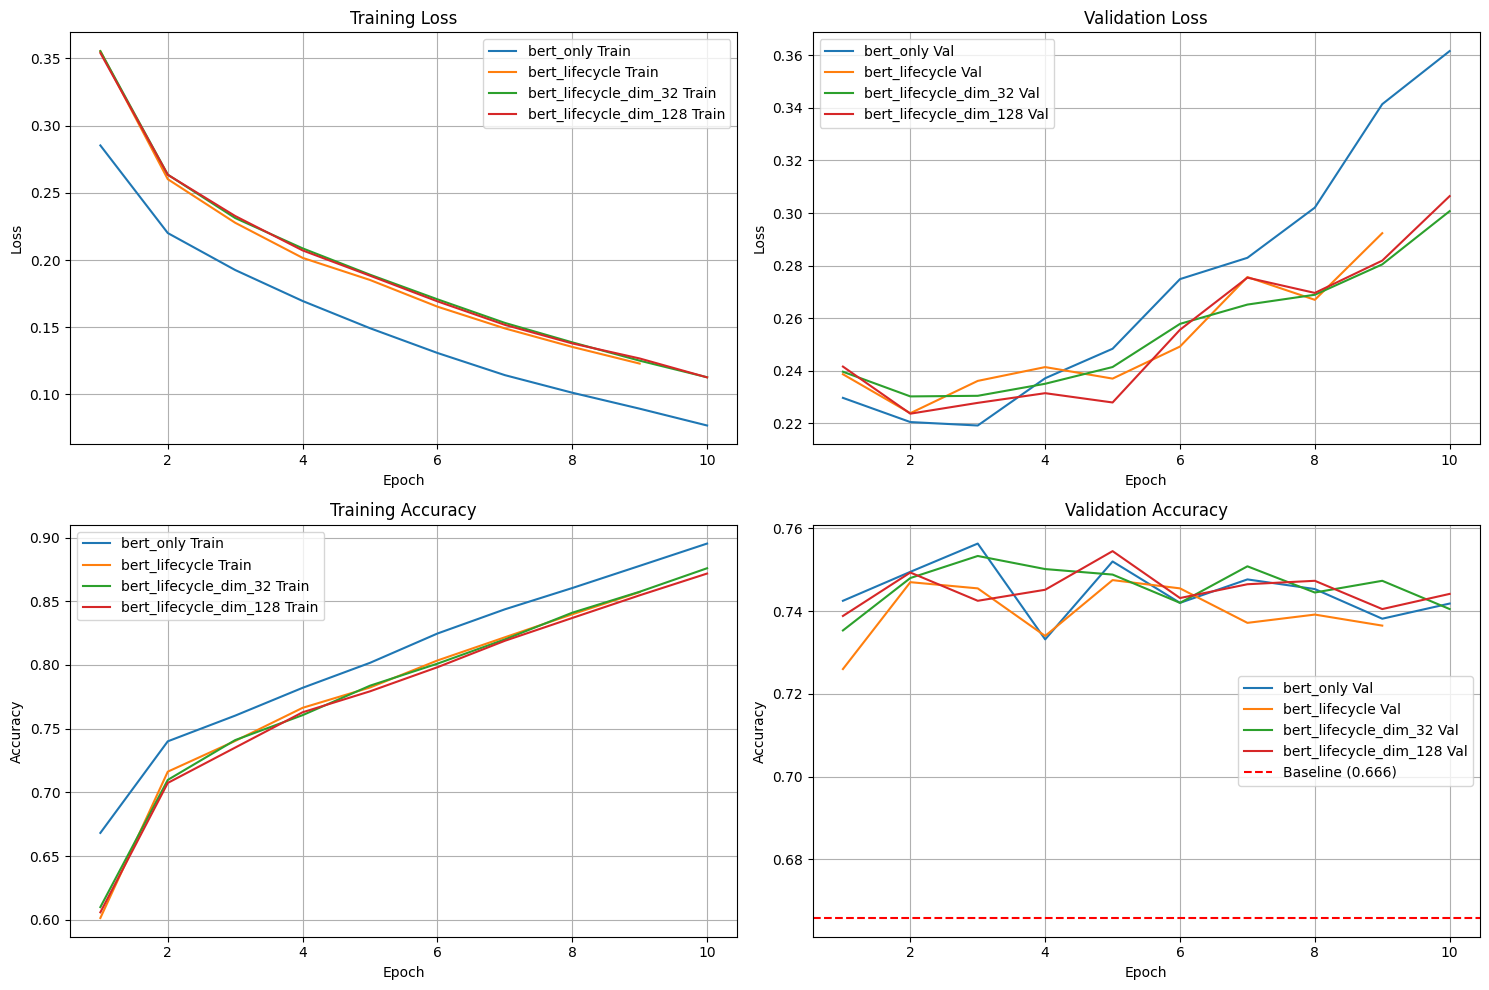

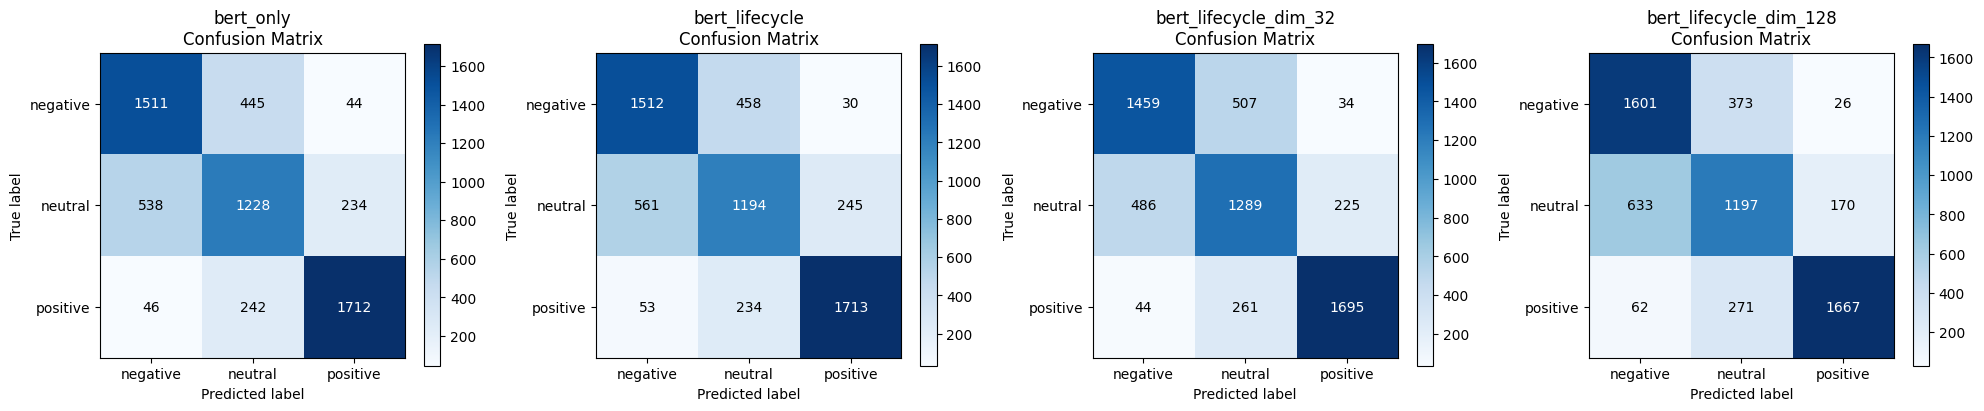

In [24]:
def plot_training_results(results):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    for model_name, result in results.items():
        if 'train_losses' in result and len(result['train_losses']) > 0:
            epochs_range = range(1, len(result['train_losses']) + 1)

            ax1.plot(epochs_range, result['train_losses'], label=f'{model_name} Train')
            ax2.plot(epochs_range, result['val_losses'], label=f'{model_name} Val')
            ax3.plot(epochs_range, result['train_accuracies'], label=f'{model_name} Train')
            ax4.plot(epochs_range, result['val_accuracies'], label=f'{model_name} Val')

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.set_title('Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    ax3.set_title('Training Accuracy')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True)

    ax4.set_title('Validation Accuracy')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.axhline(y=baseline_accuracy, color='r', linestyle='--', label=f'Baseline ({baseline_accuracy:.3f})')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results):
    n_models = len([r for r in results.values() if 'final_predictions' in r])
    if n_models == 0:
        return

    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    if n_models == 1:
        axes = [axes]

    idx = 0
    for model_name, result in results.items():
        if 'final_predictions' in result:
            cm = confusion_matrix(result['final_labels'], result['final_predictions'])

            im = axes[idx].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            axes[idx].figure.colorbar(im, ax=axes[idx])
            axes[idx].set(xticks=np.arange(cm.shape[1]),
                         yticks=np.arange(cm.shape[0]),
                         xticklabels=sentiment_encoder.classes_,
                         yticklabels=sentiment_encoder.classes_,
                         title=f'{model_name}\nConfusion Matrix',
                         ylabel='True label',
                         xlabel='Predicted label')

            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    axes[idx].text(j, i, format(cm[i, j], 'd'),
                                  ha="center", va="center",
                                  color="white" if cm[i, j] > thresh else "black")
            idx += 1

    plt.tight_layout()
    plt.show()

if 'X_train' in locals() and 'ablation_results' in locals():
    try:
        cv_results = cross_validate()
    except Exception as e:
        print(f"Cross-validation failed: {str(e)}")
        cv_results = None

if 'ablation_results' in locals():
    plot_training_results(ablation_results)
    plot_confusion_matrices(ablation_results)

In [25]:
def save_results_and_models():
    if 'ablation_results' in locals():
        results_summary = {
            'ablation_results': {k: {'best_accuracy': v['best_accuracy']} for k, v in ablation_results.items()},
            'training_config': TRAINING_CONFIG,
            'model_architecture': {
                'n_sentiments': n_sentiments,
                'n_lifecycle_stages': n_lifecycle_stages,
                'lifecycle_embedding_dim': 64
            }
        }

        if 'cv_results' in locals():
            results_summary['cross_validation'] = cv_results

        if 'performance_analysis' in locals():
            results_summary['statistical_analysis'] = performance_analysis

        results_df = pd.DataFrame([results_summary])
        results_df.to_csv('/content/drive/MyDrive/final_results_summary.csv', index=False)

        if 'bert_lifecycle' in ablation_results:
            torch.save(ablation_results['bert_lifecycle']['model'].state_dict(),
                      '/content/drive/MyDrive/best_sentiment_model_final.pth')

        print("Results and best model saved to Google Drive")
        print("Files saved:")
        print("  • final_results_summary.csv")
        print("  • best_sentiment_model_final.pth")

save_results_and_models()